<h1><b>Predicting Memorability using C3D & HMP</b></h1>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CA684/')

Mounted at /content/drive/


**Install and Import Libraries**

In [ ]:
!pip install pyprind

In [ ]:
import pandas as pd
import keras
from keras import Sequential, layers, regularizers, optimizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from natsort import natsorted,ns

**Define Functions**

In [ ]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [ ]:
# loading C3D
def read_C3D(fname):
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] 
    return C3D
  
# loading HMP
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

**Loading Features**

In [ ]:
# load the ground truth values
label_path = '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/Ground-truth/ground-truth.csv'
labels=pd.read_csv(label_path)

# Path for the features
Feat_path = '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/'

#getting video names using features' name
def getnames(featurename):
  vnames = os.listdir(Feat_path+featurename)
  return vnames

#get full path of the features using features' name 
def getpaths(featurename):
  fpath = [Feat_path+featurename+'/' + x for x in  getnames(featurename)]
  sorted = natsorted(fpath,alg=ns.IGNORECASE)
  print('Feature Path:')
  print(sorted[:5])
  return sorted

In [ ]:
#load C3D and return as an array of list
def df_C3D():
  path = getpaths('C3D')
  c3d = []
  print('Loading C3D')
  for item in path:
    c3d.append(read_C3D(item))
  print('done')
  return np.asarray(c3d)

#load HMP and return as an array of list
def df_HMP():
  path = getpaths('HMP')
  hmp = []
  print('Loading HMP')
  for item in path:
    hmp.append(read_HMP(item))
  print('done')
  return np.asarray(hmp)

In [ ]:
#loading C3D
feature1 = df_C3D()

Feature Path:
['/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/C3D/video3.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/C3D/video4.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/C3D/video6.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/C3D/video8.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/C3D/video10.txt']
Loading C3D
done


In [ ]:
#loading HMP
feature2 = df_HMP()

Feature Path:
['/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/HMP/video3.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/HMP/video4.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/HMP/video6.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/HMP/video8.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Dev-set/HMP/video10.txt']
Loading HMP
done


**Model Building**

**Using C3D Feature**

In [ ]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = feature1

In [ ]:
#Splitting dataset into test and train set with 80:20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.20, random_state=42)

In [ ]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Epoch 1/22
150/150 [==============================] - 1s 3ms/step - loss: 0.5506 - accuracy: 0.4918 - val_loss: 0.0382 - val_accuracy: 0.5308
Epoch 2/22
150/150 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.5060 - val_loss: 0.0222 - val_accuracy: 0.7042
Epoch 3/22
150/150 [==============================] - 0s 2ms/step - loss: 0.0778 - accuracy: 0.5301 - val_loss: 0.0168 - val_accuracy: 0.7100
Epoch 4/22
150/150 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.5977 - val_loss: 0.0152 - val_accuracy: 0.7100
Epoch 5/22
150/150 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.6571 - val_loss: 0.0145 - val_accuracy: 0.7100
Epoch 6/22
150/150 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.6951 - val_loss: 0.0144 - val_accuracy: 0.7100
Epoch 7/22
150/150 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.7105 - val_loss: 0.0141 - val_accuracy: 0.7100
Epoch 

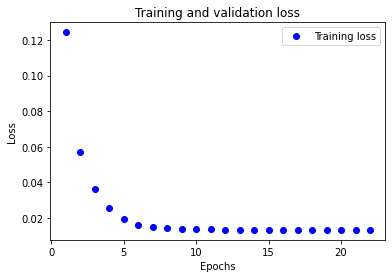

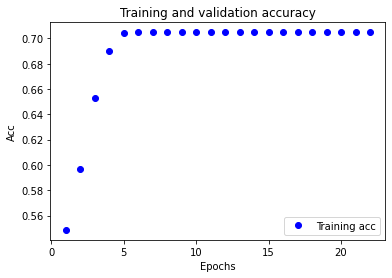

In [ ]:
# visualizing the model
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
#plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)


(1200, 2)


In [ ]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.278
The Spearman's correlation coefficient is: 0.128


**Using HMP Feature**

In [ ]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = feature2

In [ ]:
#Splitting dataset into test and train set with 80:20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.20, random_state=42)

In [ ]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Epoch 1/22
150/150 [==============================] - 2s 8ms/step - loss: 0.2297 - accuracy: 0.5661 - val_loss: 0.0240 - val_accuracy: 0.7100
Epoch 2/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0809 - accuracy: 0.5576 - val_loss: 0.0218 - val_accuracy: 0.7100
Epoch 3/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0500 - accuracy: 0.5869 - val_loss: 0.0181 - val_accuracy: 0.7100
Epoch 4/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0346 - accuracy: 0.6379 - val_loss: 0.0144 - val_accuracy: 0.7100
Epoch 5/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0256 - accuracy: 0.6789 - val_loss: 0.0145 - val_accuracy: 0.7100
Epoch 6/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0206 - accuracy: 0.7087 - val_loss: 0.0143 - val_accuracy: 0.7100
Epoch 7/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0173 - accuracy: 0.6952 - val_loss: 0.0140 - val_accuracy: 0.7100
Epoch 

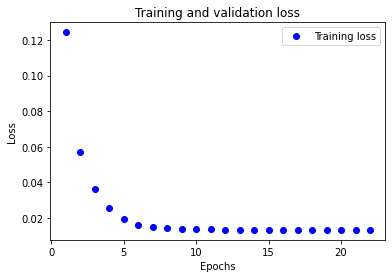

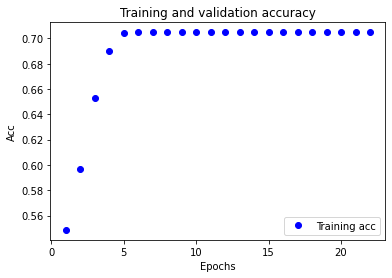

In [ ]:
# visualizing the model
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
#plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)

(1200, 2)


In [ ]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.267
The Spearman's correlation coefficient is: 0.120


**Merge C3D and HMP**

In [ ]:
#Short term and long term memorability score 
Y_NN = labels[['short-term_memorability','long-term_memorability']].values
X_NN = np.concatenate((feature1,feature2), axis=1)

In [ ]:
#Splitting dataset into test and train set with 80:20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X_NN,Y_NN, test_size=0.20, random_state=42)

In [ ]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Epoch 1/22
150/150 [==============================] - 2s 7ms/step - loss: 0.2230 - accuracy: 0.5436 - val_loss: 0.0211 - val_accuracy: 0.7100
Epoch 2/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0705 - accuracy: 0.5619 - val_loss: 0.0176 - val_accuracy: 0.7100
Epoch 3/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0499 - accuracy: 0.6129 - val_loss: 0.0151 - val_accuracy: 0.7100
Epoch 4/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0363 - accuracy: 0.6713 - val_loss: 0.0145 - val_accuracy: 0.7100
Epoch 5/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0269 - accuracy: 0.7008 - val_loss: 0.0141 - val_accuracy: 0.7100
Epoch 6/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0209 - accuracy: 0.7010 - val_loss: 0.0142 - val_accuracy: 0.7100
Epoch 7/22
150/150 [==============================] - 1s 6ms/step - loss: 0.0173 - accuracy: 0.7051 - val_loss: 0.0138 - val_accuracy: 0.7100
Epoch 

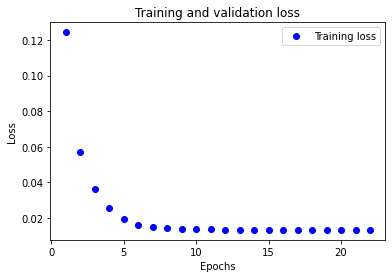

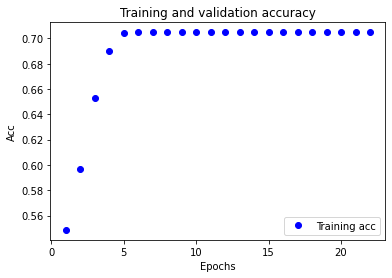

In [ ]:
# visualizing the model
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
#plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
predictionsNN = model.predict(X_test)
print(predictionsNN.shape)

(1200, 2)


In [ ]:
Get_score(predictionsNN, Y_test)

The Spearman's correlation coefficient is: 0.292
The Spearman's correlation coefficient is: 0.146


<h2><b>If we compare the three models, then we can find that we are getting better scores after merging C3D and HMP features.</b></h2>

**Load the test set**

In [ ]:
label_path = '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv'
labels_test=pd.read_csv(label_path)

#Overwriting the Feat_Path to test dataset location
Feat_path = '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/'

In [ ]:
#Overwriting the functions for getting dataset name and full path since directory is named feature_test
def getnames(featurename):
  vnames = os.listdir(Feat_path+featurename+'_test')
  return vnames

def getpaths(featurename):
  fpath = [Feat_path+featurename+'_test/' + x for x in  getnames(featurename)]
  sorted = natsorted(fpath,alg=ns.IGNORECASE)
  print('Feature Path:')
  print(sorted[:5])
  return sorted

In [ ]:
#Loading 2000 test set of C3D
f1_test = df_C3D()

#Loading 2000 test set of HMP
f2_test = df_HMP()

Feature Path:
['/content/drive/My Drive/CA684/CA684_Assignment/Test-set/C3D_test/video7494.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/C3D_test/video7495.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/C3D_test/video7496.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/C3D_test/video7497.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/C3D_test/video7498.txt']
Loading C3D
done
Feature Path:
['/content/drive/My Drive/CA684/CA684_Assignment/Test-set/HMP_test/video7494.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/HMP_test/video7495.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/HMP_test/video7496.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/HMP_test/video7497.txt', '/content/drive/My Drive/CA684/CA684_Assignment/Test-set/HMP_test/video7498.txt']
Loading HMP
done


In [ ]:
print(len(f1_test),len(f2_test))

2000 2000


In [ ]:
#Short term and long term memorability score 
Y_test = labels_test[['short-term_memorability','long-term_memorability']].values
X_test = np.concatenate((f1_test,f2_test), axis=1)
X_train = np.concatenate((feature1,feature2), axis=1)
Y_train = labels[['short-term_memorability','long-term_memorability']].values

**Build and run the model**

In [ ]:
# adding dropout and regularizers
model = Sequential()
model.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

# compiling the model 
opt = optimizers.RMSprop(lr=0.0009, rho=0.89, decay=0.0)
model.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

history = model.fit(X_train,Y_train,epochs=22,validation_data=(X_test,Y_test))

Epoch 1/22
188/188 [==============================] - 2s 7ms/step - loss: 0.2058 - accuracy: 0.5282 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/22
188/188 [==============================] - 1s 6ms/step - loss: 0.0659 - accuracy: 0.5779 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/22
188/188 [==============================] - 1s 6ms/step - loss: 0.0395 - accuracy: 0.6399 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/22
188/188 [==============================] - 1s 6ms/step - loss: 0.0290 - accuracy: 0.6717 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/22
188/188 [==============================] - 1s 6ms/step - loss: 0.0210 - accuracy: 0.7058 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/22
188/188 [==============================] - 1s 6ms/step - loss: 0.0172 - accuracy: 0.7120 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/22
188/188 [==============================] - 1s 6ms/step - loss: 0.0150 - accuracy: 0.6998 - val_loss: nan - val_accuracy: 1.0000
Epoch 8/22
188/188 [=======

In [ ]:
predictionsNN_test = model.predict(X_test)
print(predictionsNN_test.shape)

(2000, 2)


**Print the predictions**

In [ ]:
print(predictionsNN_test)

[[0.87247455 0.7910394 ]
 [0.8395027  0.76593286]
 [0.8852565  0.8000093 ]
 ...
 [0.89026564 0.80434436]
 [0.845789   0.77262765]
 [0.89969134 0.81251556]]


**Save the predictions**

In [ ]:
import pandas as pd
prediction = pd.DataFrame({'video': natsorted(labels_test['video']),
                    'short-term_memorability': [row[0] for row in predictionsNN_test],
                    'long-term_memorability':[row[1] for row in predictionsNN_test]
                        })

In [ ]:
prediction.head()

,video,short-term_memorability,long-term_memorability
0,7494,0.872475,0.791039
1,7495,0.839503,0.765933
2,7496,0.885257,0.800009
3,7497,0.859811,0.781256
4,7498,0.865513,0.785755


In [ ]:
prediction.to_csv('./Soumi_Mitra_20210300_predictions.csv')

**Save the model**

In [ ]:
model.save('./final_model_memory.h5')